In [1]:
# /mnt/ssd/hpa-single-cell-image-classification

## Imports

In [1]:
import os

import typing as tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn as nn
import torchvision.transforms.v2 as transforms
from torchvision.io import read_image
from torchvision import models

from sklearn.model_selection import train_test_split

from collections import Counter

palette = "Set2"
sns.set(style="whitegrid", font_scale=0.8, palette=palette)

## HPA Dataset Class

In [2]:
class HPADataset():
    def __init__(
        self, 
        dir: str,
        labels_csv: str,
        indices: tp.Optional[tp.List[int]] = None,
        transform: tp.Optional[transforms.Compose] = None,
    ):
        '''
        Initializes the ImageDataset object.
        Parameters:
            dir: str
                The directory where the images are stored.
            labels_csv: str
                Path to the CSV file containing labels.
            indices: Optional[List[int]]
                Indices to use for this subset of the dataset.
            transform: Optional[transforms.Compose]
                If not None, the images will be transformed.
        '''
        # Salvar os argumentos
        self.dir = dir
        self.transform = transform

        # Listar todos os arquivos no diretório
        self.filenames = os.listdir(self.dir)

        # Extrair a parte do nome do arquivo antes do primeiro "_"
        self.filenames = [filename.split("_")[0] for filename in self.filenames]

        # Remover duplicatas convertendo a lista para um set e depois de volta para uma lista
        self.filenames = list(set(self.filenames))

        # Ordenar a lista de arquivos
        self.filenames.sort()

        # Carregar o arquivo CSV com os rótulos
        self.labels = pd.read_csv(labels_csv).set_index("ID")

        # Ordenar os rótulos de acordo com a ordem dos arquivos
        self.labels = self.labels.loc[self.filenames]

        # Converter a coluna 'Label' de strings para listas de inteiros
        self.labels['Label'] = self.labels['Label'].apply(lambda x: list(map(int, x.split('|'))))

        # Transformar os rótulos em binário
        self.binary_labels = torch.zeros((len(self.labels), 19), dtype=torch.float32)

        # Para cada rótulo, definir os índices correspondentes como 1
        for i, label_list in enumerate(self.labels['Label']):
            # Certifique-se de que label_list é uma lista de inteiros
            for label in label_list:
                self.binary_labels[i, label] = 1

        # Se índices são fornecidos, selecionar apenas esses índices
        if indices is not None:
            self.filenames = [self.filenames[i] for i in indices]
            self.binary_labels = self.binary_labels[indices]

    def __len__(self) -> int:
        '''
        Returns the number of images in the dataset.
        Returns:
            int
                The number of images in the dataset.
        '''
        return len(self.filenames)

    def __getitem__(self, idx) -> tp.Tuple[torch.Tensor, torch.Tensor]:
        '''
        Returns the image and its label.
        Parameters:
            idx: int
                The index of the image to be returned.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]
                A tuple containing the image and its label.
        '''
        # Checar se o índice é válido
        if idx >= self.__len__():
            raise IndexError
        
        # Pegar todas a imagens
        colors = ["_green", "_blue", "_red", "_yellow"]
        images = [read_image(os.path.join(self.dir, self.filenames[idx] + color + ".png")) for color in colors]
        image = torch.cat(images, 0)

        # Aplicar transformações
        if self.transform:
            image = self.transform(image)
        
        # Pegar os rótulos
        label = self.binary_labels[idx]

        return image, label
    
    def set_transform(self, transform: tp.Optional[transforms.Compose]) -> None:
        '''
        Sets the transform attribute.
        Parameters:
            transform: Optional[transforms.Compose]
                The transform to be set.
        '''
        self.transform = transform

## Train and Valid Split

In [3]:
classes_map = {
    0: "Nucleoplasm",
    1: "Nuclear membrane",
    2: "Nucleoli",
    3: "Nucleoli fibrillar center",
    4: "Nuclear speckles",
    5: "Nuclear bodies",
    6: "Endoplasmic reticulum",
    7: "Golgi apparatus",
    8: "Intermediate filaments",
    9: "Actin filaments",
    10: "Microtubules",
    11: "Mitotic spindle",
    12: "Centrosome",
    13: "Plasma membrane",
    14: "Mitochondria",
    15: "Aggresome",
    16: "Cytosol",
    17: "Vesicles and punctate cytosolic patterns",
    18: "Negative",
}

In [4]:
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/train'
labels_csv = '/mnt/ssd/hpa-single-cell-image-classification/train.csv'

In [5]:
def train_valid_split_multilabel(dataset: HPADataset, test_size=0.25):
    indices = list(range(len(dataset)))

    # Criar uma matriz binária para representar a presença de cada rótulo em cada amostra
    binary_labels = np.zeros((len(dataset), len(classes_map)))

    for i, labels in enumerate(dataset.labels.values.flatten()):
        binary_labels[i, labels] = 1

    # Agora usar esta matriz binária para estratificação
    train_indices, valid_indices = train_test_split(
        indices,
        test_size=test_size,
        stratify=binary_labels.sum(axis=1),  # Estratificar baseado no número de rótulos por amostra
        random_state=78
    )
    
    train_dataset = HPADataset(dir=dataset_dir, labels_csv=labels_csv, indices=train_indices, transform=dataset.transform)
    valid_dataset = HPADataset(dir=dataset_dir, labels_csv=labels_csv, indices=valid_indices, transform=dataset.transform)
    
    return train_dataset, valid_dataset

In [7]:
# Transformações
transform = transforms.Compose([
    transforms.Resize((512, 512)), 
    transforms.ToImage(), # Transformar de tensor para imagem
    transforms.ToDtype(torch.float32, scale=True)  
])

# Carregar o dataset
dataset = HPADataset(dir=dataset_dir, labels_csv=labels_csv, transform=transform)
train_dataset, valid_dataset = train_valid_split_multilabel(dataset)

In [8]:
dataset.__getitem__(0)

(Image([[[0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0118, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0196, 0.0235]],
 
        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
        [[0.0510, 0.0235, 0.0431,  ..., 0.0039, 0.0078, 0.0078],
         [0.0314, 0.0784, 0.1020,  ..., 0.0078, 0.0039, 0.0039],
         [0.0039, 0.0392, 0.1059,  ..., 0.0157, 0.0078, 

In [9]:
dataset.labels.head()

,Label
ID,
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[12]
0020af02-bbba-11e8-b2ba-ac1f6b6435d0,"[16, 2]"


In [10]:
dataset.filenames[:5]

['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
 '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
 '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0',
 '001838f8-bbca-11e8-b2bc-ac1f6b6435d0',
 '0020af02-bbba-11e8-b2ba-ac1f6b6435d0']

In [11]:
dataset.__len__()

21806

## Data Analysis

In [12]:
# Achatar a estrutura, removendo a camada extra de arrays
flattened_tensor = torch.cat([item[0] for item in dataset.labels.values])

# Contar a frequência dos labels
label_counts = Counter(flattened_tensor.numpy())

# Mapeando os números para os nomes das classes
label_counts_named = {classes_map[k]: v for k, v in label_counts.items()}

# Ordenar os labels pela frequência (do maior para o menor)
sorted_label_counts_named = dict(sorted(label_counts_named.items(), key=lambda item: item[1], reverse=True))

# Cores para os gráficos
num_classes = len(sorted_label_counts_named)
palette = sns.color_palette("pastel", num_classes)

# Plotar a frequência dos labels ordenados com nomes
plt.figure(figsize=(10, 8))
bars = plt.barh(list(sorted_label_counts_named.keys()), list(sorted_label_counts_named.values()), color=palette)
plt.xlabel('Frequência')
plt.ylabel('Rótulos')
plt.title('Frequência por Rótulo')
plt.gca().invert_yaxis()  # Inverte o eixo y para mostrar o maior no topo

# Adicionar as quantidades ao lado das barras
for bar in bars:
    width = bar.get_width()  # Largura da barra
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.show()


TypeError: expected Tensor as element 0 in argument 0, but got list

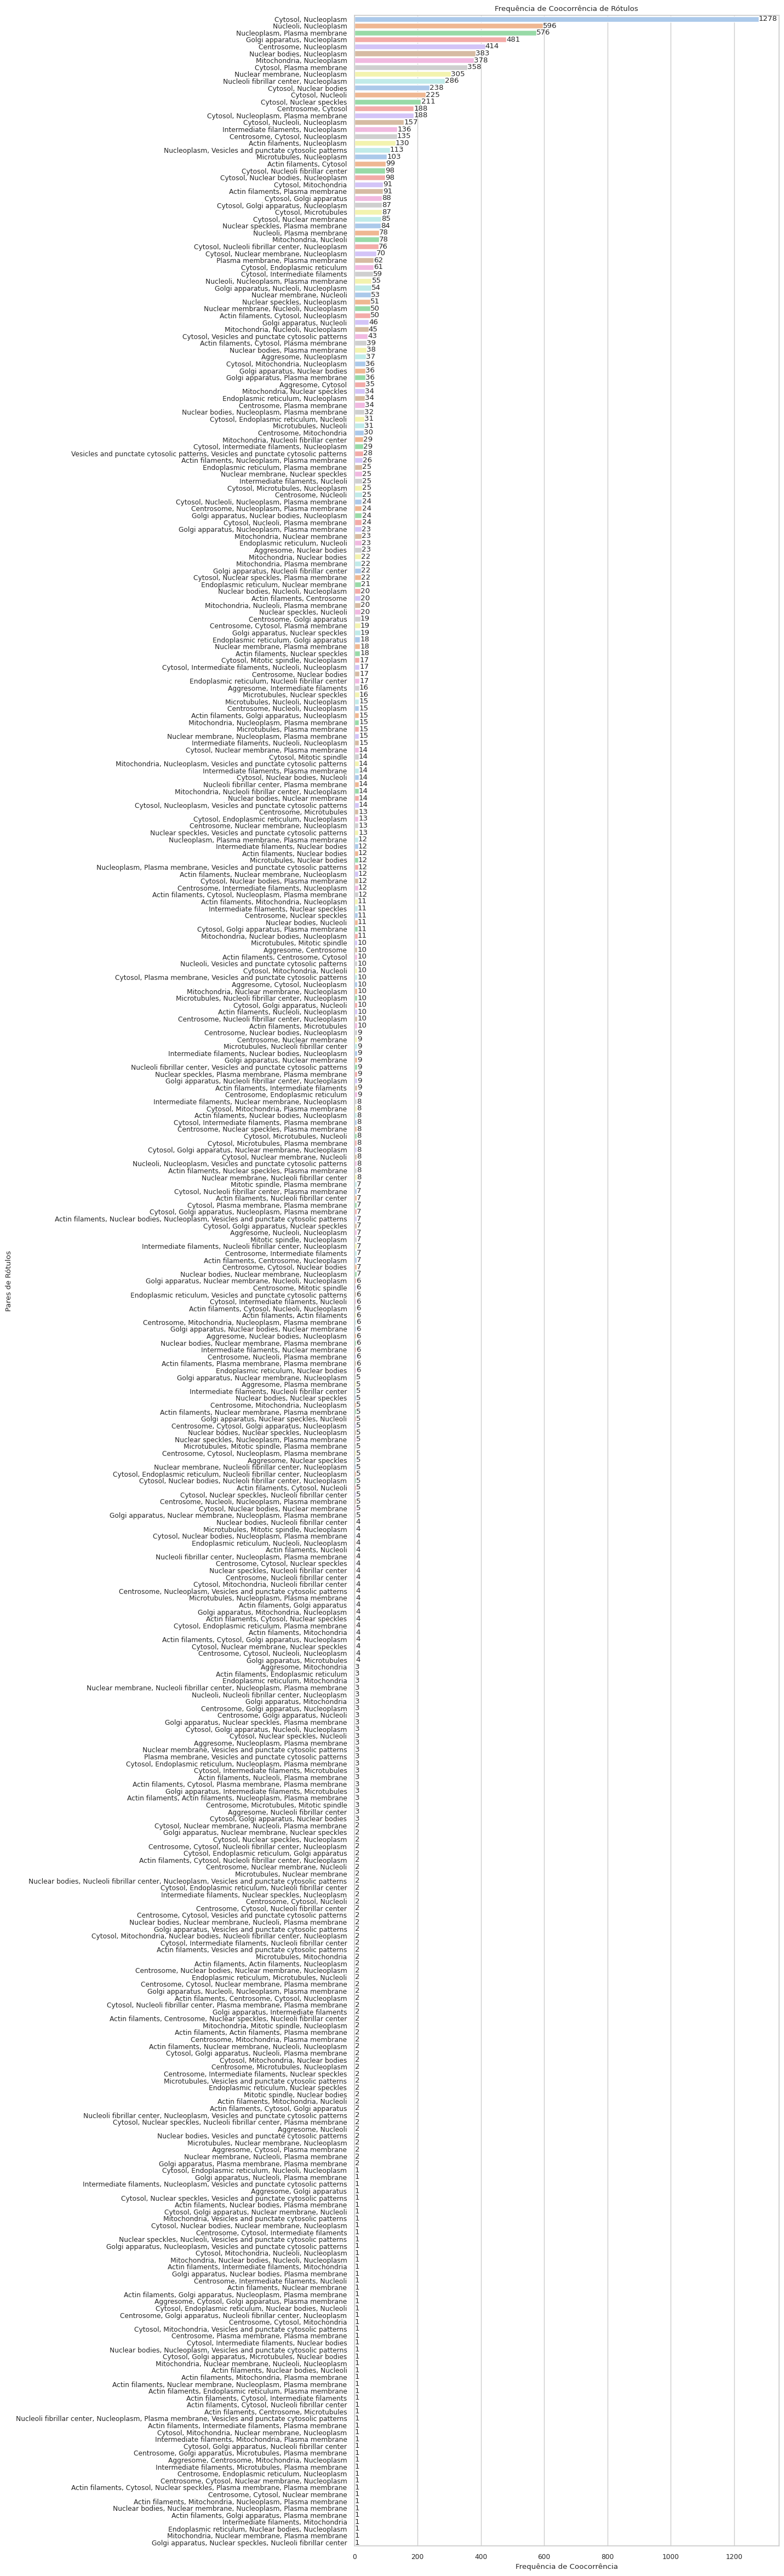

In [14]:
# Inicializar a matriz de coocorrência
num_labels = len(classes_map)
cooccurrence_matrix = {}

# Iterar sobre todas as linhas do dataset
for index, row in dataset.labels.iterrows():
    labels = row['Label']
    if len(labels) == 1:
        continue
    labels_name = [classes_map[int(label)] for label in labels]
    labels_name = sorted(labels_name)
    labels_name = ", ".join(labels_name)
    try:
        cooccurrence_matrix[labels_name] += 1
    except KeyError:
        cooccurrence_matrix[labels_name] = 1

# Criar uma lista de pares de rótulos e suas frequências
pairs = list(cooccurrence_matrix.keys())
frequencies = list(cooccurrence_matrix.values())

# Ordenar os pares de rótulos pela frequência
sorted_pairs, sorted_frequencies = zip(*sorted(zip(pairs, frequencies), key=lambda x: x[1], reverse=True))

# Plotar o gráfico de barras
plt.figure(figsize=(10, 60))
sns.barplot(x=sorted_frequencies, y=sorted_pairs, hue=sorted_pairs, dodge=False, palette='pastel', legend=False)

plt.xlabel('Frequência de Coocorrência')
plt.ylabel('Pares de Rótulos')
plt.title('Frequência de Coocorrência de Rótulos')

# Adicionar os valores das coocorrências nas barras
for i, value in enumerate(sorted_frequencies):
    plt.text(value + 0.1, i, str(value), va='center')

plt.show()

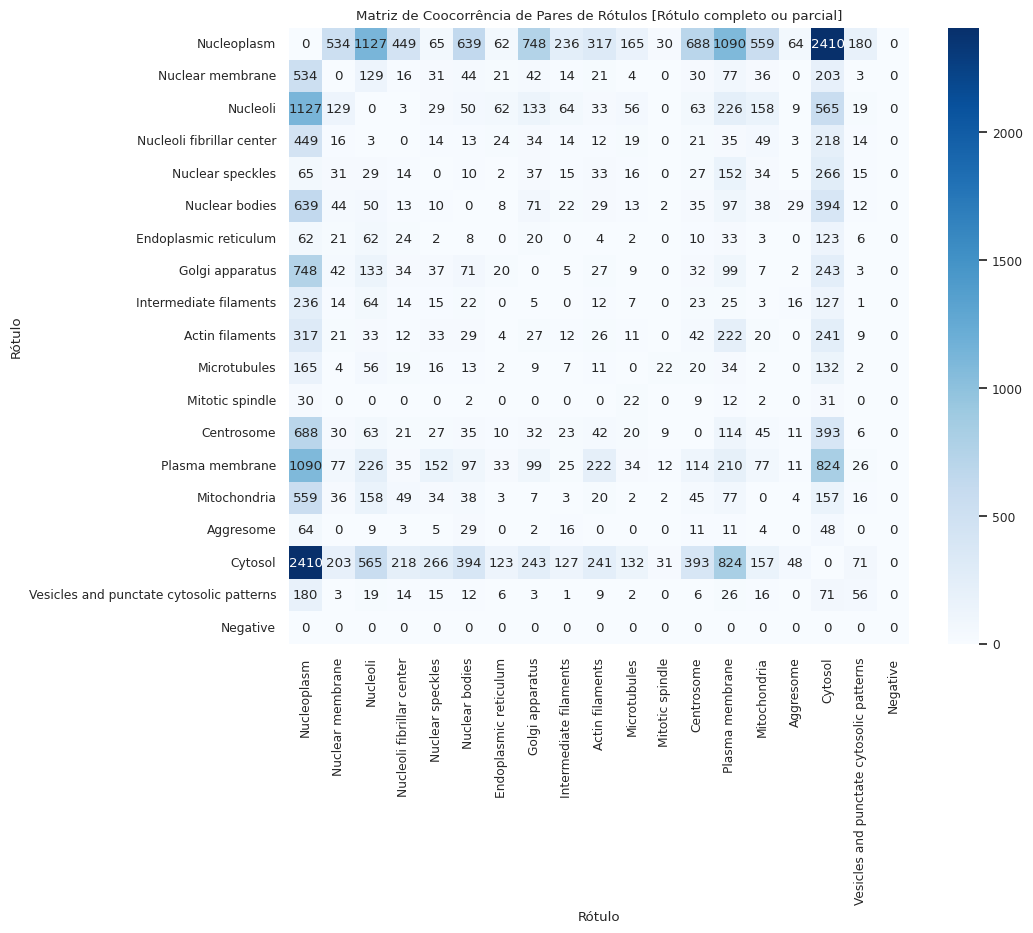

In [15]:
# Inicializar a matriz de coocorrência
num_labels = len(classes_map)
cooccurrence_matrix = np.zeros((num_labels, num_labels), dtype=int)

# Iterar sobre todas as linhas do dataset
for index, row in dataset.labels.iterrows():
    labels = row['Label']
    
    # Atualizar a matriz de coocorrência para cada par de rótulos
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            label_i = labels[i]
            label_j = labels[j]
            cooccurrence_matrix[label_i, label_j] += 1
            cooccurrence_matrix[label_j, label_i] += 1  # Simétrico

# Criar o mapa de calor da matriz de coocorrência
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cooccurrence_matrix, annot=True, cmap='Blues', fmt='d',
                 xticklabels=[classes_map[i] for i in range(num_labels)],
                 yticklabels=[classes_map[i] for i in range(num_labels)])
plt.xlabel('Rótulo')
plt.ylabel('Rótulo')
plt.title('Matriz de Coocorrência de Pares de Rótulos [Rótulo completo ou parcial]')
plt.show()


## Train and Valid Analysis

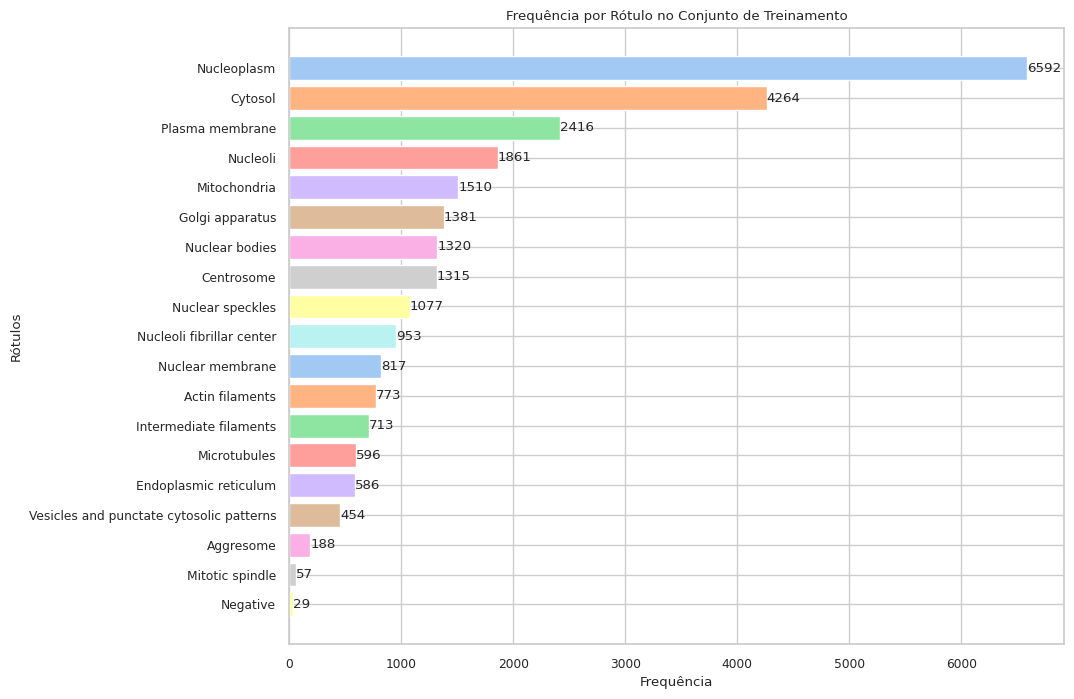

In [16]:
# Achatar a estrutura, removendo a camada extra de arrays
flattened_tensor = torch.cat([item[0] for item in train_dataset.labels.values])

# Contar a frequência dos labels
label_counts = Counter(flattened_tensor.numpy())

# Mapeando os números para os nomes das classes
label_counts_named = {classes_map[k]: v for k, v in label_counts.items()}

# Ordenar os labels pela frequência (do maior para o menor)
sorted_label_counts_named = dict(sorted(label_counts_named.items(), key=lambda item: item[1], reverse=True))

# Cores para os gráficos
num_classes = len(sorted_label_counts_named)
palette = sns.color_palette("pastel", num_classes)

# Plotar a frequência dos labels ordenados com nomes
plt.figure(figsize=(10, 8))
bars = plt.barh(list(sorted_label_counts_named.keys()), list(sorted_label_counts_named.values()), color=palette)
plt.xlabel('Frequência')
plt.ylabel('Rótulos')
plt.title('Frequência por Rótulo no Conjunto de Treinamento')
plt.gca().invert_yaxis()  # Inverte o eixo y para mostrar o maior no topo

# Adicionar as quantidades ao lado das barras
for bar in bars:
    width = bar.get_width()  # Largura da barra
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.show()


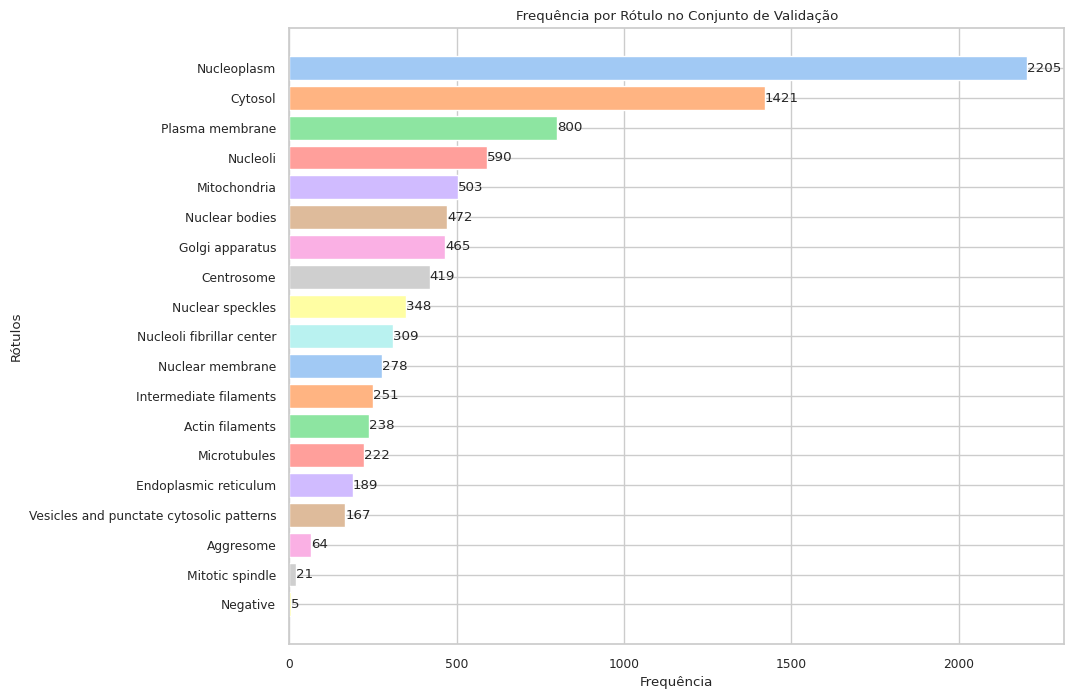

In [17]:
# Achatar a estrutura, removendo a camada extra de arrays
flattened_tensor = torch.cat([item[0] for item in valid_dataset.labels.values])

# Contar a frequência dos labels
label_counts = Counter(flattened_tensor.numpy())

# Mapeando os números para os nomes das classes
label_counts_named = {classes_map[k]: v for k, v in label_counts.items()}

# Ordenar os labels pela frequência (do maior para o menor)
sorted_label_counts_named = dict(sorted(label_counts_named.items(), key=lambda item: item[1], reverse=True))

# Cores para os gráficos
num_classes = len(sorted_label_counts_named)
palette = sns.color_palette("pastel", num_classes)

# Plotar a frequência dos labels ordenados com nomes
plt.figure(figsize=(10, 8))
bars = plt.barh(list(sorted_label_counts_named.keys()), list(sorted_label_counts_named.values()), color=palette)
plt.xlabel('Frequência')
plt.ylabel('Rótulos')
plt.title('Frequência por Rótulo no Conjunto de Validação')
plt.gca().invert_yaxis()  # Inverte o eixo y para mostrar o maior no topo

# Adicionar as quantidades ao lado das barras
for bar in bars:
    width = bar.get_width()  # Largura da barra
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', va='center')

plt.show()


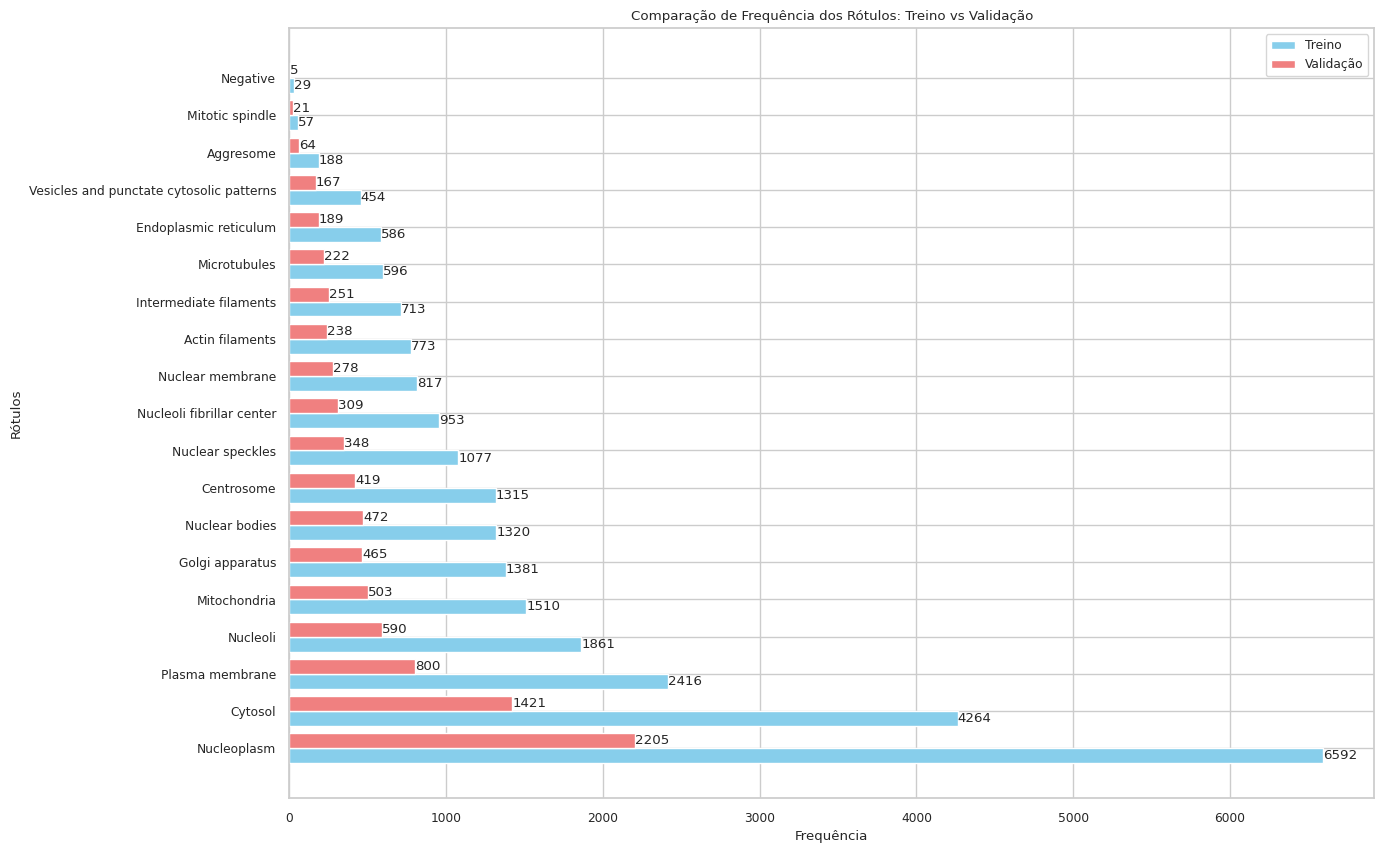

In [18]:
def plot_label_distribution(train_dataset, valid_dataset, classes_map):
    def get_label_counts(dataset):
        flattened_tensor = torch.cat([item[0] for item in dataset.labels.values])
        label_counts = Counter(flattened_tensor.numpy())
        label_counts_named = {classes_map[k]: v for k, v in label_counts.items()}
        sorted_label_counts_named = dict(sorted(label_counts_named.items(), key=lambda item: item[1], reverse=True))
        return sorted_label_counts_named

    # Obter a distribuição dos rótulos nos conjuntos de treino e validação
    train_label_counts = get_label_counts(train_dataset)
    valid_label_counts = get_label_counts(valid_dataset)

    # Preparar os dados para o gráfico
    labels = list(train_label_counts.keys())
    train_counts = list(train_label_counts.values())
    valid_counts = [valid_label_counts.get(label, 0) for label in labels]  # 0 para labels que não estão no conjunto de validação

    # Plotar os gráficos de barras
    x = range(len(labels))
    width = 0.4

    plt.figure(figsize=(14, 10))
    plt.barh([i - width/2 for i in x], train_counts, height=width, label='Treino', color='skyblue')
    plt.barh([i + width/2 for i in x], valid_counts, height=width, label='Validação', color='lightcoral')
    plt.xlabel('Frequência')
    plt.ylabel('Rótulos')
    plt.title('Comparação de Frequência dos Rótulos: Treino vs Validação')
    plt.yticks(x, labels)
    plt.legend()

    # Adicionar as quantidades ao lado das barras
    for i, (train_count, valid_count) in enumerate(zip(train_counts, valid_counts)):
        plt.text(train_count, i - width/2, f'{train_count}', va='center')
        plt.text(valid_count, i + width/2, f'{valid_count}', va='center')

    plt.show()

# Exemplo de uso:
plot_label_distribution(train_dataset, valid_dataset, classes_map)

In [19]:
train_filenames = set(train_dataset.filenames)
valid_filenames = set(valid_dataset.filenames)

if len(train_filenames.intersection(valid_filenames)) == 0:
    print("Não há nenhum nome de arquivo duplicado entre os conjuntos de treinamento e teste.")
else:
    print("Há pelo menos um nome de arquivo duplicado entre os conjuntos de treinamento e teste.")

Não há nenhum nome de arquivo duplicado entre os conjuntos de treinamento e teste.


## Examples

In [11]:
train_dataset.__getitem__(0)[0][0] # green
train_dataset.__getitem__(0)[0][1] # blue
train_dataset.__getitem__(0)[0][2] # red
train_dataset.__getitem__(0)[0][3] # nir

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

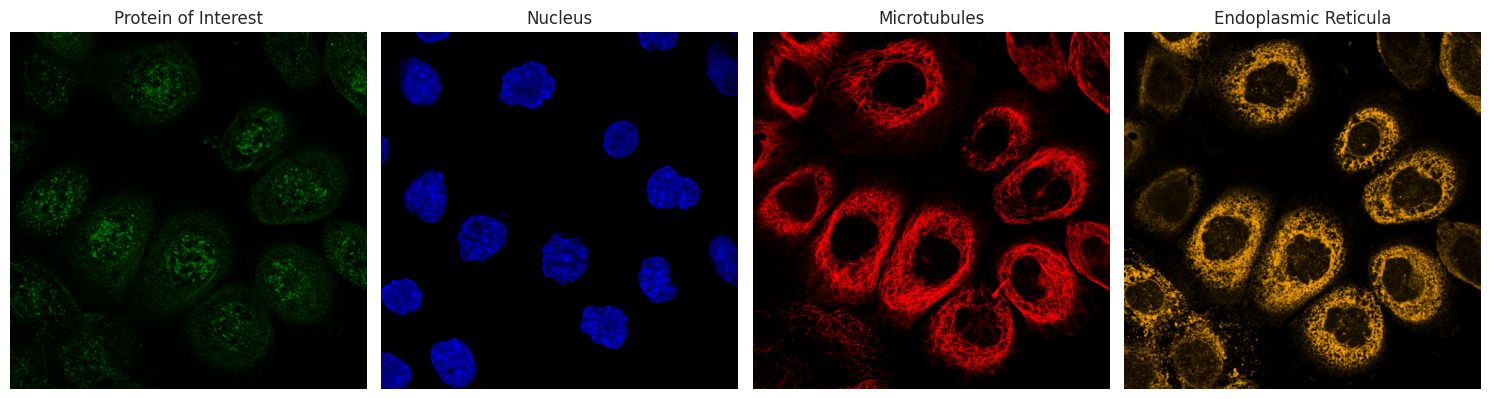

In [15]:
# Define a function to create a colormap where 0 is black and > 0 is the specified color
def create_colormap(color):
    from matplotlib.colors import LinearSegmentedColormap
    return LinearSegmentedColormap.from_list('custom_cmap', ['black', color])

def plot_image_with_4_channels(dataset, index):
    """
    Plota uma imagem com 4 canais do dataset em subplots.
    
    Args:
        dataset: O dataset que contém as imagens.
        index: O índice da amostra da qual a imagem deve ser extraída.
    """
    # Obtém a imagem com 4 canais
    image = dataset.__getitem__(index)[0]
    
    # Verifica se a imagem tem 4 canais
    assert image.shape[0] == 4, "A imagem deve ter 4 canais."
    
    # Configura a figura com 4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    
    # Nomes dos canais para os títulos
    channel_names = ['green', 'blue', 'red', 'orange']
    text_names = ['Protein of Interest', 'Nucleus', 'Microtubules', 'Endoplasmic Reticula']
    
    for i in range(4):
        # Plota cada canal
        axs[i].imshow(image[i].numpy(), cmap=create_colormap(channel_names[i]), vmin=0, vmax=1)
        axs[i].set_title(text_names[i], fontsize=12)
        axs[i].axis('off')  # Remove os eixos
    
    # Ajusta o layout
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_image_with_4_channels(train_dataset, 15)

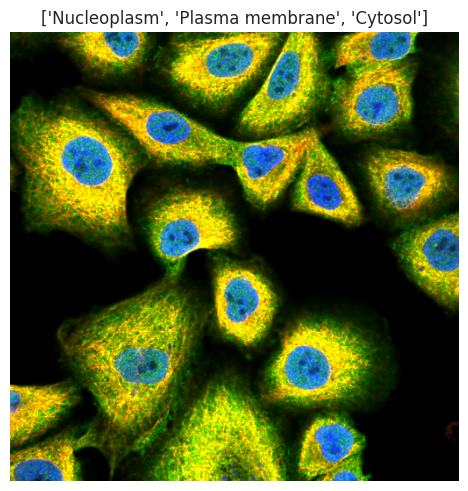

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_with_4_channels_overlaid(dataset, index):
    """
    Plota uma imagem com 4 canais do dataset sobreposta em uma única figura,
    garantindo que todas as cores apareçam corretamente.
    
    Args:
        dataset: O dataset que contém as imagens.
        index: O índice da amostra da qual a imagem deve ser extraída.
    """
    # Obtém a imagem com 4 canais
    image = dataset.__getitem__(index)[0]
    labels = dataset.__getitem__(index)[1]
    labels_names = [classes_map[i] for i in range(len(labels)) if labels[i] == 1]
    
    # Verifica se a imagem tem 4 canais
    assert image.shape[0] == 4, "A imagem deve ter 4 canais."
    
    # Nomes dos canais e suas cores
    channel_colors = {
        'green': (0, 1, 0, 0),  # verde com alpha 0.5
        'blue': (0, 0, 1, 0.3),   # azul com alpha 0.5
        'red': (1, 0, 0, 0.3),    # vermelho com alpha 0.5
        'orange': (1, 0.6, 0, 0.3) # laranja com alpha 0.5
    }

    # Cria a figura
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Inicializa uma matriz RGB vazia com zeros (3 canais de cores)
    combined_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.float32)
    
    # Plota cada canal com a cor correspondente e transparência
    for i, (channel_name, color) in enumerate(channel_colors.items()):
        channel_image = image[i].numpy()
        # Normaliza o canal para garantir que os valores estão entre 0 e 1
        channel_image = (channel_image - np.min(channel_image)) / (np.max(channel_image) - np.min(channel_image) + 1e-5)
        
        # Adiciona o canal colorido à imagem combinada
        for j in range(3):  # Para cada canal RGB
            combined_image[:, :, j] += channel_image * color[j]
    
    # Garante que os valores da imagem combinada não ultrapassem 1
    combined_image = np.clip(combined_image, 0, 1)
    
    # Mostra a imagem final
    ax.imshow(combined_image)
    ax.axis('off')
    # Coloca os rótulos dessa imagem na legenda
    plt.title(labels_names, fontsize=12)
    plt.tight_layout()
    plt.show()


# Exemplo de uso:
plot_image_with_4_channels_overlaid(train_dataset, 14)

In [39]:
print(train_dataset.__getitem__(14)[1])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0.])


## Classification

In [121]:
# Carregar o modelo EfficientNet-B0 pré-treinado
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

In [122]:
# Obter a primeira camada convolucional
first_conv_layer = model.features[0][0]

# Criar uma nova camada convolucional com 4 canais de entrada, mantendo os outros parâmetros
new_conv_layer = nn.Conv2d(
    in_channels=4,  # Mudar para 4 canais de entrada
    out_channels=first_conv_layer.out_channels,
    kernel_size=first_conv_layer.kernel_size,
    stride=first_conv_layer.stride,
    padding=first_conv_layer.padding,
    bias=first_conv_layer.bias is not None
)

# Copiar os pesos dos 3 primeiros canais da camada original para a nova camada
with torch.no_grad():
    new_conv_layer.weight[:, :3, :, :] = first_conv_layer.weight

    # Inicializar os pesos do quarto canal com valores aleatórios entre -1 e 1
    new_conv_layer.weight[:, 3:, :, :] = 2 * torch.rand_like(first_conv_layer.weight[:, :1, :, :]) - 1

# Substituir a camada original pela nova
model.features[0][0] = new_conv_layer

# Modificar a última camada para classificação multirrótulo
num_labels = 19
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_labels)

# Aplicar a função sigmoid na saída para multirrótulo
model.add_module('sigmoid', torch.nn.Sigmoid())

# Verifique a arquitetura para garantir que a mudança foi feita
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [123]:
criterion = nn.BCEWithLogitsLoss()  # Loss function para multirrótulo
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Otimizador

In [124]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
# Supõe-se que você já tem um DataLoader chamado 'train_loader'
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mover o modelo para a GPU, se disponível
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:  # Lembre-se que inputs deve ter 4 canais e labels devem ser multirrótulo
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zerando os gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calcular a loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Atualizar os pesos
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Treinamento completo!")


In [ ]:
torch.save(model.state_dict(), 'efficientnet_b0_multilabel.pth')